In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import rc, animation, cm
import numpy as np
from IPython.display import HTML, Image
rc("figure",figsize=(8,8),facecolor='202020')
rc("axes", facecolor='202020')
plt.style.use(['dark_background'])

# Programming Exercise 4
Consider the 1-dimensional Euler equations that model an ideal gas with density $\rho$, velocity $v$, specific energy $E$, and pressure $P$:
\begin{align*}
\partial_t\rho + \partial_x(\rho v) &= 0\\
\partial_t(\rho v) + \partial_x(\rho v^2+P) &= 0\\
\partial_t E + \partial_x\left[v(E+P)\right] &= 0
\end{align*}

We can relate each of the variables like so:
\begin{align*}
P &= (\gamma-1)(E-\rho\frac{v^2}{2})\\
E &= \frac{1}{2}\rho u^2 + c_\nu \rho T\\
  &= \frac{1}{2}\rho u^2 + \frac{\rho RT}{\gamma-1}\\
  &= \frac{1}{2}\rho u^2 + \frac{P}{\gamma-1}
\end{align*}
We can then write a system of unknowns in terms of the conserved quantities:
\begin{gather*}
U = \begin{bmatrix}U_1\\U_2\\U_3\end{bmatrix} = \begin{bmatrix}\rho \\ \rho v \\ E\end{bmatrix} ,
F = \begin{bmatrix}F_1\\F_2\\F_3\end{bmatrix} = \begin{bmatrix}\rho v \\ P + \rho v^2\\(P+E)u\end{bmatrix}
\end{gather*}
And we can write the flux as a vector of flux functions in terms of $U$:
\begin{gather*}
F = \begin{bmatrix}U_2\\U_3(\gamma-1)+\frac{3-\gamma}{2}\frac{U_2^2}{U_1}\\\frac{U_2U_3}{U_1}\gamma-\frac{1}{2}(\gamma-1)\frac{U_2^3}{U_1^2}\end{bmatrix}
\end{gather*}
The Jacobian of the flux vector is given by:
\begin{gather*}
(\nabla_UF)^T = A = \begin{bmatrix} 0 & 1 & 0 \\ \frac{1/2}(\gamma-3)v^2 & (3-\gamma) & \gamma-1 \\ \frac{1}{2}(\gamma-2)v^3 - \frac{\gamma Pv}{\rho(\gamma-1)} & \frac{v^2}{2}(3-2\gamma)+\frac{\gamma P}{\rho(\gamma-1)} & \gamma v\end{bmatrix}
\end{gather*}
If the speed of sound is given by:
\begin{gather*}
c = \sqrt{\frac{\gamma P}{\rho}}
\end{gather*}
The eigenvalues of $A$ are given by $v+c$, $v$, and $v-c$.

In [2]:
#set up constants and parameters

def setup(tc, xL, xR, xJ, n, gamma):
    x = np.linspace(xL, xR, n)
    u = np.zeros((3,n))
    for i in range(n):
        #if we are the the left region
        if x[i] <= xJ:
            u[0][i] = tc["rhoL"]
            u[1][i] = tc["rhoL"]*tc["vL"]
            u[2][i] = 0.5*np.power(tc["vL"],2)*tc["rhoL"]+tc["pL"]/(gamma-1)
        else:
            u[0][i] = tc["rhoR"]
            u[1][i] = tc["rhoR"]*tc["vR"]
            u[2][i] = 0.5*np.power(tc["vR"],2)*tc["rhoR"]+tc["pR"]/(gamma-1)
    return x, u, gamma, x[1]-x[0]

#recover velocity, density, pressure from conserved quantities
def extract(u, gamma):
    info = np.zeros(u.shape)
    info[0] = u[0]
    info[1] = u[1]/u[0]
    info[2] = (gamma-1)*(u[2] - 0.5*u[1]*info[0])
    return info

#initial datum setup
test_case_1 = {"rhoL":1,'vL':0,'pL':1,'rhoR':0.125,'vR':0,'pR':0.1}
test_case_2 = {'rhoL':1,'vL':-1,'pL':0.4,'rhoR':1,'vR':1,'pR':0.4}

Next, we need to define a numerical scheme and numerical flux functions.
\begin{gather*}
u_j^{n+1} = u_i^n - \frac{\Delta t}{\Delta x}(\tilde{F}(u_j^n,u_{j+1}^n) - \tilde{F}(u_{j-1}^n,u_j^n))
\end{gather*}
where
\begin{gather*}
F(u_j^n,u_{j+1}^n)=\begin{cases}f(u_j^n) & 0 \leq a_L\\\frac{a_Rf(u_j^n)-a_Lf(u_{j+1}^n)+a_La_R(u_{j+1}^n-u_j^n)}{a_R-a_L} & a_L\leq0\leq a_R \\ f(u_{j+1}^n) & 0\geq a_R\end{cases}
\end{gather*}
$a_L = min(\lambda(A(u_j)),\lambda(A(u_{j+1}))$ and $a_R = max(|\lambda(A(u_j))|,|\lambda(A(u_{j+1}))|)$

In [3]:
def flux(u, gamma):
    f = np.zeros(u.shape)
    f[0] = u[1]
    f[1] = (gamma-1)*u[2]+(3-gamma)/2 * np.power(u[1],2)/u[0]
    f[2] = gamma*u[1]*u[2]/u[0] - 0.5*(gamma-1)*np.power(u[1],3)/np.power(u[0],2)
    return f

def eigvals(u, gamma):
    infos_u = extract(u,gamma)
    mach_u = np.sqrt(gamma*infos_u[2]/infos_u[0])
    eigs = np.array([infos_u[1]-mach_u, infos_u[1], infos_u[1]+mach_u])
    return eigs


def HLL_numerical_flux(u,v,gamma):
    fu = flux(u,gamma)
    fv = flux(v,gamma)
    eigs = np.array([eigvals(u,gamma),eigvals(v,gamma)])
    aL = np.min(eigs)
    aR = np.max(np.abs(eigs))
    if aL >= 0:
        return fu
    elif aR <= 0: 
        return fv
    else:
        return (aR*fu-aL*fv+aL*aR*(v-u))/(aR-aL)
    
def jac(u,gamma):
    return np.array([[0, 1, 0],
                     [0.5*(gamma-3)*np.power(u[1]/u[0],2),(3-gamma)*u[1]/u[0], gamma-1],
                     [-gamma*u[1]*u[2]/np.power(u[0],2)+(gamma-1)*np.power(u[1]/u[0],3),
                       gamma*u[2]/u[0]-1.5*(gamma-1)*np.power(u[1]/u[0],2), u[1]/u[0]*gamma]])

def advance_solution(u, dx, gamma, cfl_factor):
    n = u.shape[1]
    u_next = np.zeros(u.shape)
    
    dt = cfl_factor*dx/np.max(np.abs(eigvals(u,gamma)))
    
    for jx in range(n):
        #handle left boundary
        if jx == 0:
            u_next[:,jx] = u[:,jx] - dt/dx*(HLL_numerical_flux(u[:,0],u[:,1],gamma)-
                                            HLL_numerical_flux(u[:,0],u[:,0],gamma))
        # handle right boundary
        elif jx == n-1:
            u_next[:,jx] = u[:,jx] - dt/dx*(HLL_numerical_flux(u[:,n-1],u[:,n-1],gamma)-
                                            HLL_numerical_flux(u[:,n-2],u[:,n-1],gamma))
        else:
            u_next[:,jx] = u[:,jx] - dt/dx*(HLL_numerical_flux(u[:,jx],u[:,jx+1],gamma)-
                                            HLL_numerical_flux(u[:,jx-1],u[:,jx],gamma))
    
    return u_next, dt
    

In [9]:
# set up the initial conditions and information
x, u, gamma, dx = setup(test_case_2, 0, 1, 0.5, 101, 1.4)
u_record = [extract(u,gamma)]
t_final = 0.5
t = 0
tsteps = 0

while t < t_final:
    u, dt = advance_solution(u,dx,gamma,0.5)
    u_record.append(extract(u,gamma))
    t += dt
    tsteps += 1
u_record = np.array(u_record)
print("Completed in {} steps.".format(tsteps))

Completed in 183 steps.


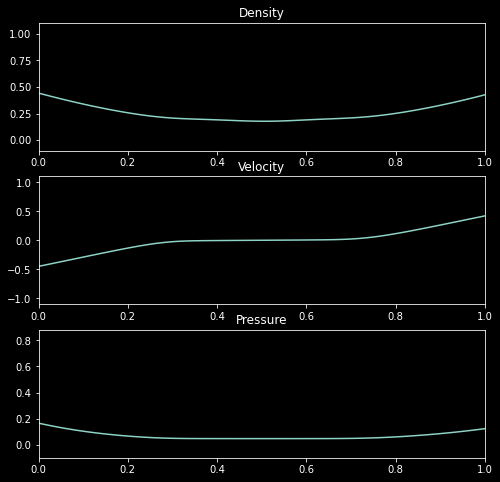

In [8]:
fig, axs = plt.subplots(3,1)
artists = []
axs[0].set_title("Density")
axs[1].set_title("Velocity")
axs[2].set_title("Pressure")
for i in range(3):
    axs[i].set_xlim((0,1))
    axs[i].set_ylim((min(-0.1,np.min(u_record[:,i,:]-0.1)),
                     1.1*np.max(u_record[:,i,:])))
    a,  = axs[i].plot([],[])
    artists.append(a)
def init_anim():
    for a in artists:
        a.set_data([],[])
    return artists
def anim_func(i):
    for j in range(3):
        artists[j].set_data(x,u_record[i][j,:])
    return artists
anim = animation.FuncAnimation(fig,anim_func,init_func=init_anim,
                               frames=tsteps,
                               interval=100,blit=True)
HTML(anim.to_jshtml())

In [10]:
anim.save("wow2.gif",writer="imagemagick",fps=10)